In [1]:
import numpy as np
from tensorflow.keras.layers import Input
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from srgan import *

2023-07-04 00:04:56.651378: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-04 00:04:57.066567: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Train

In [2]:
hr_shape = (256, 256, 3)
lr_shape = (64, 64, 3)

In [3]:
def load_image(path):
  img = Image.open(path)
  return np.asarray(img) / 255.0

def filename(num):
  zeros = 5 - len(str(num))
  return '0'*zeros + str(num) + '.png'

In [4]:
data_lr = []
data_hr = []
for i in tqdm(range(0, 10404, 4)):
  f = filename(i)
  data_lr.append(load_image(f'mc_64/{f}'))
  data_hr.append(load_image(f'real_256/{f}'))

100%|██████████| 2601/2601 [00:03<00:00, 663.23it/s]


In [5]:
train_lr, test_lr, train_hr, test_hr = train_test_split(data_lr, data_hr, test_size=0.2)

In [6]:
train_hr = np.array(train_hr)
train_lr = np.array(train_lr)
test_lr = np.array(test_lr)
test_hr = np.array(test_hr)

In [7]:
lr_ip = Input(shape=(64,64,3))
hr_ip = Input(shape=(256,256,3))

In [8]:
generator = create_gen(lr_ip)
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam",      
  metrics=['accuracy'])
vgg = build_vgg2()
vgg.trainable = False
gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)
gan_model.compile(loss=["binary_crossentropy","mse"], loss_weights=
  [1e-3, 1], optimizer="adam")

2023-07-04 00:05:04.818709: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-04 00:05:04.835488: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-04 00:05:04.835685: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [9]:
epochs = 10
batch_size = 6
for e in range(epochs):
    gen_label = np.zeros((batch_size, 1))
    real_label = np.ones((batch_size,1))
    g_losses = []
    d_losses = []
    for it in tqdm(range(int(train_hr.shape[0] / batch_size))):
        start_idx = it * batch_size
        end_idx = start_idx + batch_size
        lr_imgs = train_lr[start_idx:end_idx]
        hr_imgs = train_hr[start_idx:end_idx]
        gen_imgs = generator.predict_on_batch(lr_imgs)
        #Dont forget to make the discriminator trainable
        discriminator.trainable = True
        
        #Train the discriminator
        d_loss_gen = discriminator.train_on_batch(gen_imgs,
          gen_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs,
          real_label)
        discriminator.trainable = False
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)
        image_features = vgg.predict_on_batch(hr_imgs)
        
        #Train the generator
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], 
          [real_label, image_features])
        
        d_losses.append(d_loss)
        g_losses.append(g_loss)

    generator.save_weights(f'./checkpoints/my_checkpoint_epoch0{e}.h5')
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

  0%|          | 0/346 [00:00<?, ?it/s]2023-07-04 00:05:06.191139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [6,64,64,3]
	 [[{{node Placeholder/_0}}]]
2023-07-04 00:05:07.025994: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-07-04 00:05:10.538592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [6,1]
	 [[{{node Placeholder/_1}}]]
2023-07-04 00:05:11.975115: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. T

epoch: 1 g_loss: 0.26101740451820327 d_loss: [19.5226955   0.91353565]


  0%|          | 0/346 [00:00<?, ?it/s]2023-07-04 00:09:46.005204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [6,64,64,3]
	 [[{{node Placeholder/_0}}]]
2023-07-04 00:09:46.113050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [6,1]
	 [[{{node Placeholder/_1}}]]
2023-07-04 00:09:46.192156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placehol

epoch: 2 g_loss: 0.31436459501570013 d_loss: [1.81200278 0.98314065]


  0%|          | 0/346 [00:00<?, ?it/s]2023-07-04 00:13:51.029968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [6,64,64,3]
	 [[{{node Placeholder/_0}}]]
2023-07-04 00:13:51.142838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [6,1]
	 [[{{node Placeholder/_1}}]]
2023-07-04 00:13:51.223652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placehol

KeyboardInterrupt: 

In [12]:
from glob import glob
import random
import cv2
import matplotlib.pyplot as plt

In [13]:
def random_image():
    paths = glob('mc_64/*.png')
    path = random.choice(paths)
    image = cv2.imread(path)[..., ::-1]
    image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_LINEAR) / 255
    return image

(64, 64, 3) float64 0.9921568627450981


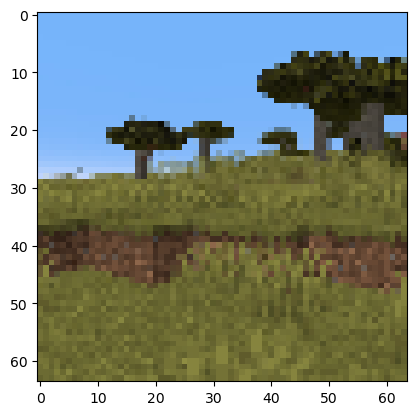

In [14]:
mc_image = random_image()
print(mc_image.shape, mc_image.dtype, np.max(mc_image))
plt.imshow(mc_image)

In [17]:
real_image = generator.predict_on_batch(mc_image[None, ...])[0]

2023-07-04 00:15:20.290783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1,64,64,3]
	 [[{{node Placeholder/_0}}]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


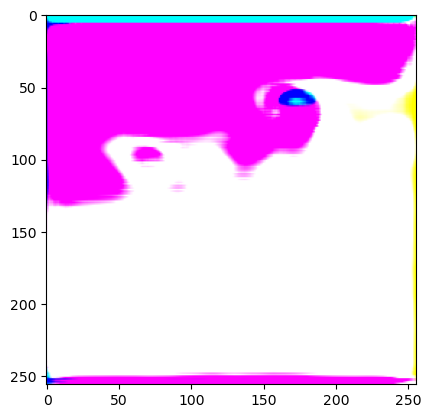

In [18]:
plt.imshow(real_image)